In [1]:
# prerequisite package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

%matplotlib inline

# set up better resolution for figures
# matplotlib
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# seaborn
sb.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sb.set_context('notebook')
sb.set_style("ticks")

# for statistical test and annotation
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests
from statannotations.Annotator import Annotator

# CCLE

### 1. Read data

In [2]:
# check final output files
!ls ../output_raw

1_RefDNN_CCLE.csv              2_lococv_elasticnet_GDSC.csv
1_RefDNN_CCLE_test.csv         2_lococv_randomforest_CCLE.csv
1_RefDNN_GDSC.csv              2_lococv_randomforest_GDSC.csv
1_RefDNN_GDSC_test.csv         3_lodocv_RefDNN_CCLE.csv
1_elasticnet_CCLE.csv          3_lodocv_RefDNN_GDSC.csv
1_elasticnet_GDSC.csv          3_lodocv_elasticnet_CCLE.csv
1_randomforest_CCLE.csv        3_lodocv_elasticnet_GDSC.csv
1_randomforest_GDSC.csv        3_lodocv_randomforest_CCLE.csv
2_lococv_RefDNN_CCLE.csv       3_lodocv_randomforest_GDSC.csv
2_lococv_RefDNN_GDSC.csv       4_biomarker_CCLE.csv
2_lococv_elasticnet_CCLE.csv   4_biomarker_GDSC.csv


In [3]:
CCLE_RefDNN = pd.read_csv("../output_raw/1_RefDNN_CCLE.csv", index_col=[0])
CCLE_RefDNN

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,Hidden_units,Learning_rate_ftrl,Learning_rate_adam,L1_regularization_strength,L2_regularization_strength
0,0.910917,0.918571,0.934593,0.926513,0.956691,0.961084,128,0.000053,0.006110,0.001000,0.001000
1,0.920524,0.908192,0.961136,0.933914,0.963903,0.964140,4,0.000047,0.001526,0.001000,57.597040
2,0.910044,0.909220,0.942647,0.925632,0.959614,0.968587,111,0.000335,0.000104,2.407966,0.002248
3,0.898690,0.913295,0.918605,0.915942,0.949319,0.954301,52,0.000098,0.003898,13.838811,0.139356
4,0.920455,0.918571,0.949778,0.933914,0.941732,0.938389,97,0.031279,0.000127,100.000000,18.199876


In [4]:
CCLE_RefDNN_test = pd.read_csv("../output_raw/1_RefDNN_CCLE_test.csv", index_col=[0])
CCLE_RefDNN_test

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,Hidden_units,Learning_rate_adam
0,0.900437,0.874172,0.972018,0.920502,0.932335,0.931346,83,0.038287
1,0.886463,0.860158,0.964497,0.909344,0.902708,0.915728,128,0.021100
2,0.873362,0.856948,0.940209,0.896650,0.922922,0.931051,128,0.001155
3,0.763319,0.771131,0.861919,0.814001,0.837330,0.869874,108,0.000157
4,0.753497,0.751232,0.884058,0.812250,0.841075,0.871361,41,0.011571


In [5]:
CCLE_elasticnet = pd.read_csv("../output_raw/1_elasticnet_CCLE.csv", index_col=[0])
CCLE_elasticnet

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,ALPHA,L1_RATIO,ETA0
0,0.410480,0.525253,0.076471,0.133504,0.488302,0.581922,0.003811,0.560330,0.025232
1,0.408734,0.000000,0.000000,0.000000,0.500000,0.591266,0.000042,0.712256,0.047901
2,0.596507,0.596507,1.000000,0.747265,0.525909,0.629927,0.100000,0.659228,0.000010
3,0.600000,0.600000,1.000000,0.750000,0.500000,0.600000,0.010671,0.115356,0.000010
4,0.590035,0.590035,1.000000,0.742166,0.522009,0.619222,0.100000,0.586248,0.071912


Why does Elastic Net have extreme values for recall, precision, and F1?
For the second row, there was an error:  
```
/home/ec2-user/anaconda3/envs/RefDNN/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
```

Some discussion here:  
https://github.com/scikit-learn/scikit-learn/issues/14876  

Precision = TP / (TP + FP):  

- if y_true and y_pred are all negative: return 1.0 + warning (if zero_division=1) otherwise 0 + warning
- if y_true all negative, y_pred some positive, return 0 as usual as TP=0 and FP>0, no warning
- if y_pred all negative, y_true some positive, return 0.0 + warning (no matter zero_division value). 

Recall = TP / (TP + FN):  

- if y_true and y_pred are all negative: return 1.0 + warning (if zero_division=1) otherwise 0 + warning
- if y_true all negative, y_pred some positive, return 0 + warning (no matter zero_division value). 
- if y_pred all negative, y_true some positive, return 0 as usual as TP=0 and FN>0, no warning


Basically, in our case, it's possible that 
1. the true labels are all negative, and the model predict some positive and some negative; or   
2. there are some positive and some negative but the model predicts all negative.  

In the both scenarios, there's just no TP (so TP=0), so precision/recall/f1 will all be 0.  
(We know it's not "y_true and y_pred are all negative", because in that case accuracy should be 1.)

We should remove those 0 values.  
It looks like Elastic Net tends to get recall=1 (Basically no false negatives). Reason is unclear.

In [6]:
CCLE_randomforest = pd.read_csv("../output_raw/1_randomforest_CCLE.csv", index_col=[0])
CCLE_randomforest

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,N_ESTIMTORS,MAX_DEPTH
0,0.604367,0.605101,0.994220,0.752324,0.468891,0.577146,35,3
1,0.582533,0.586084,0.979136,0.733259,0.457925,0.541308,23,3
2,0.592140,0.600365,0.957787,0.738082,0.510661,0.606948,10,3
3,0.586900,0.591359,0.971893,0.735311,0.501370,0.587398,11,3
4,0.590909,0.591549,0.994083,0.741722,0.514172,0.588869,81,3


### 2. Data wrangling and cleaning

In [7]:
# make the data tidy for visualization
CCLE_RefDNN_metrics = CCLE_RefDNN[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
CCLE_RefDNN_metrics_tidy = pd.melt(CCLE_RefDNN_metrics, value_vars=list(CCLE_RefDNN_metrics), var_name='metric', value_name='value')
CCLE_RefDNN_metrics_tidy['model'] = 'RefDNN'

CCLE_RefDNN_test_metrics = CCLE_RefDNN_test[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
CCLE_RefDNN_test_metrics_tidy = pd.melt(CCLE_RefDNN_test_metrics, value_vars=list(CCLE_RefDNN_test_metrics), var_name='metric', value_name='value')
CCLE_RefDNN_test_metrics_tidy['model'] = 'RefDNN-test'

CCLE_elasticnet_metrics = CCLE_elasticnet[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
CCLE_elasticnet_metrics_tidy = pd.melt(CCLE_elasticnet_metrics, value_vars=list(CCLE_elasticnet_metrics), var_name='metric', value_name='value')
CCLE_elasticnet_metrics_tidy['model'] = 'Elastic Net'

CCLE_randomforest_metrics = CCLE_randomforest[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
CCLE_randomforest_metrics_tidy = pd.melt(CCLE_randomforest_metrics, value_vars=list(CCLE_randomforest_metrics), var_name='metric', value_name='value')
CCLE_randomforest_metrics_tidy['model'] = 'Random Forest'

CCLE_metrics_tidy = pd.concat([CCLE_RefDNN_metrics_tidy, CCLE_RefDNN_test_metrics_tidy, CCLE_elasticnet_metrics_tidy, CCLE_randomforest_metrics_tidy], ignore_index=True)

CCLE_metrics_tidy = CCLE_metrics_tidy[CCLE_metrics_tidy['value'] > 0]
CCLE_metrics_tidy

,metric,value,model
0,Accuracy,0.910917,RefDNN
1,Accuracy,0.920524,RefDNN
2,Accuracy,0.910044,RefDNN
3,Accuracy,0.898690,RefDNN
4,Accuracy,0.920455,RefDNN
...,...,...,...
115,AUCPR,0.577146,Random Forest
116,AUCPR,0.541308,Random Forest
117,AUCPR,0.606948,Random Forest
118,AUCPR,0.587398,Random Forest


In [8]:
# calculate statistics
CCLE_statistics = CCLE_metrics_tidy.groupby(['model', 'metric'])['value'].describe()[['mean', 'std']]
CCLE_statistics = CCLE_statistics.reset_index().melt(id_vars=['model', 'metric'], value_vars=['mean','std'], var_name='statistics', value_name='value')
CCLE_statistics = CCLE_statistics.sort_values(by=['model','statistics']).pivot(index='metric', columns=['model','statistics'], values=['value'])
CCLE_statistics.columns = [col[1]+' ('+col[2]+')' for col in CCLE_statistics.columns.values]
CCLE_statistics.to_csv('../analysis_output/1_Bayesian_CCLE_metrics.csv')
CCLE_statistics

,Elastic Net (mean),Elastic Net (std),Random Forest (mean),Random Forest (std),RefDNN (mean),RefDNN (std),RefDNN-test (mean),RefDNN-test (std)
metric,,,,,,,,
AUCPR,0.604467,0.019802,0.580334,0.024312,0.957300,0.011780,0.903872,0.031012
AUCROC,0.507244,0.016048,0.490604,0.025559,0.954252,0.008788,0.887274,0.045189
Accuracy,0.521151,0.101890,0.591370,0.008182,0.912126,0.009031,0.835415,0.071032
F1,0.593234,0.306503,0.740139,0.007514,0.927183,0.007413,0.870550,0.053099
Precision,0.577949,0.035372,0.594892,0.007672,0.913570,0.004948,0.822728,0.056992
Recall,0.769118,0.461765,0.979424,0.015482,0.941352,0.016025,0.924540,0.049134


### 3. A quick visualization

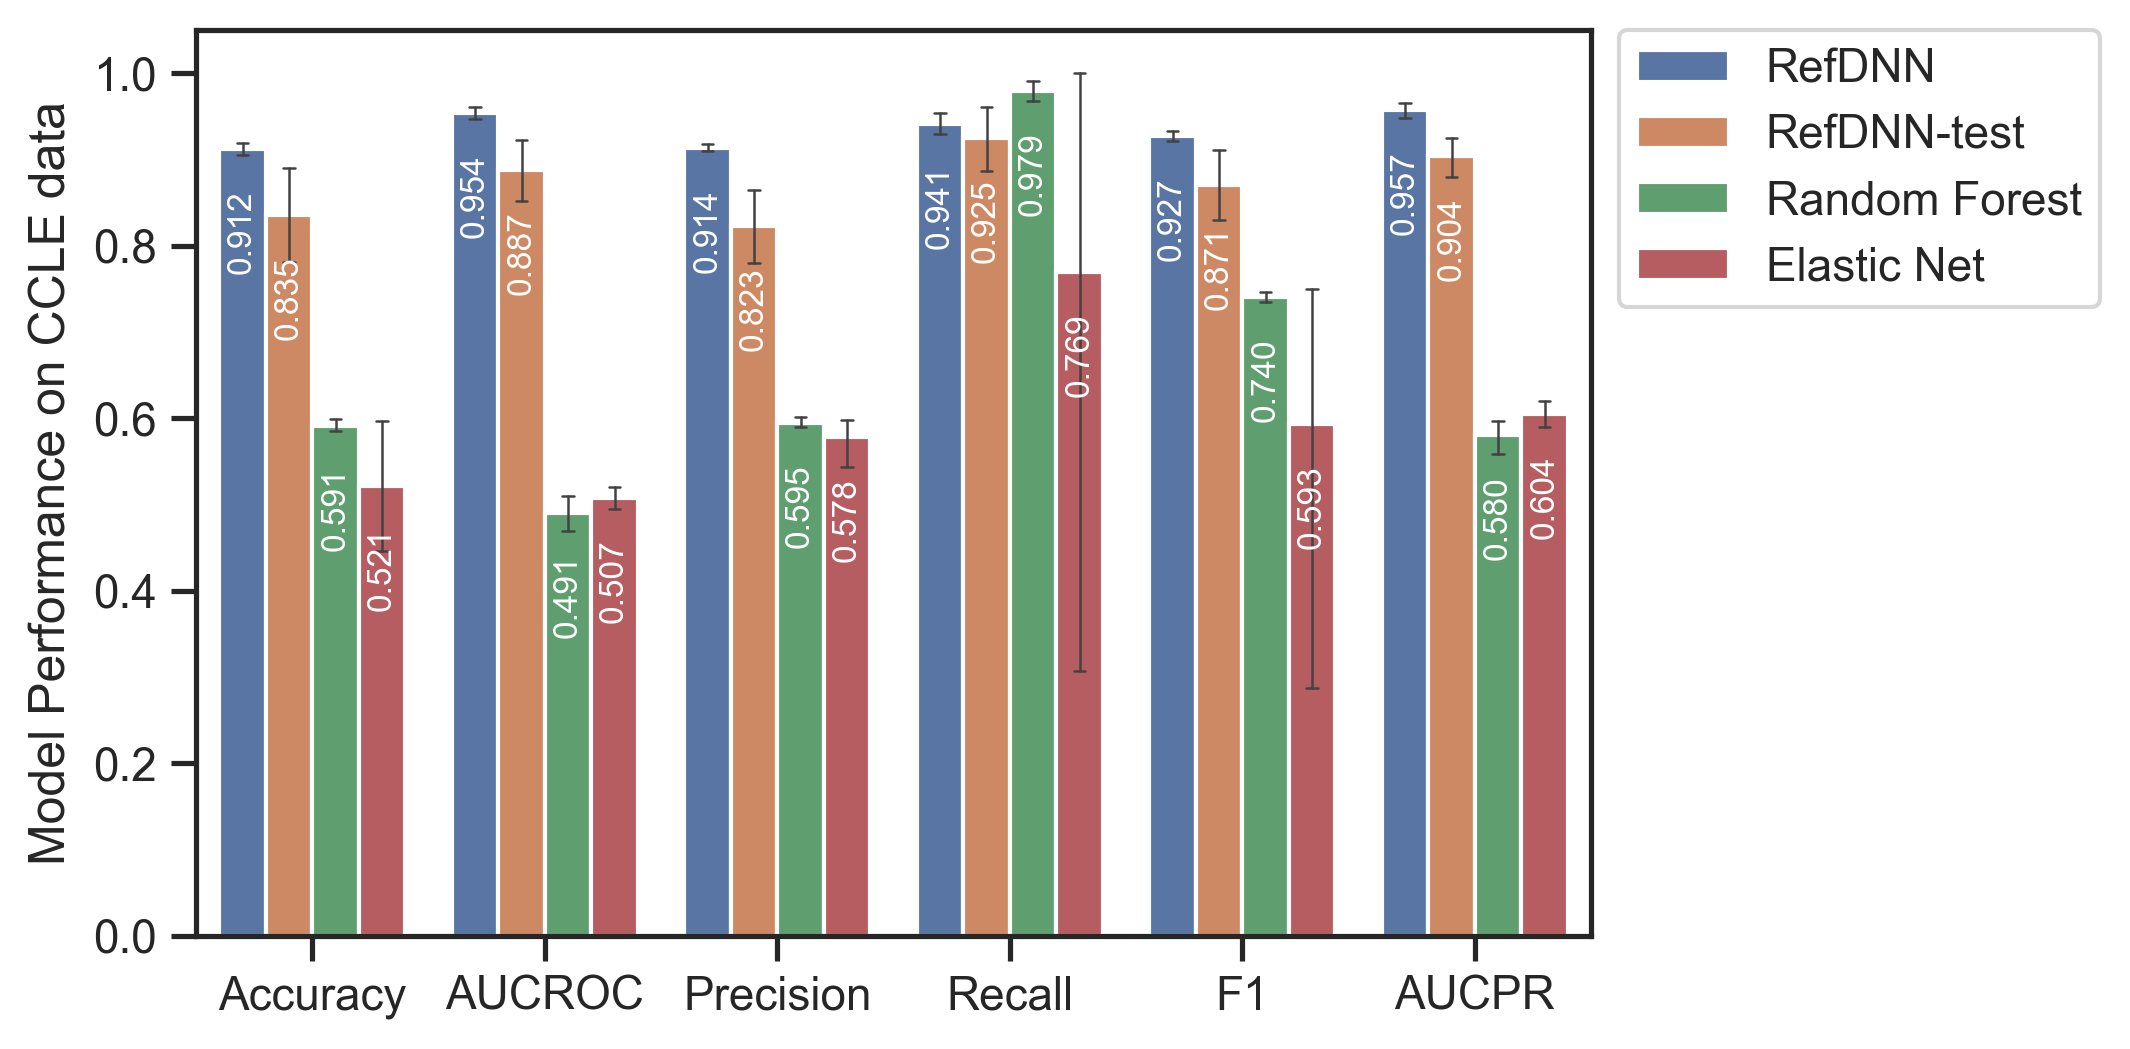

In [9]:
models = ['RefDNN', 'RefDNN-test', 'Random Forest', 'Elastic Net']
metrics = ['Accuracy', 'AUCROC', 'Precision', 'Recall', 'F1', 'AUCPR']
ax = sb.barplot(data=CCLE_metrics_tidy, x='metric', y='value', hue = 'model', 
           hue_order=models, order=metrics, errwidth=0.6, capsize=.05);
for i in ax.containers:
    ax.bar_label(i, size=8, fmt='%.3f', padding= -30, rotation=90, color='white')
plt.xlabel('')
plt.ylabel('Model Performance on CCLE data');
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### 4. Statistical test

In [10]:
p_values_df_CCLE = pd.DataFrame()
p_values_df_CCLE['metric'] = metrics
p_values_test, p_values_rf, p_values_en = [], [], []

for metric in metrics:
    refDNN_values = list(CCLE_metrics_tidy[(CCLE_metrics_tidy['metric']==metric) & (CCLE_metrics_tidy['model']=='RefDNN')]['value'])
    refDNN_test_values = list(CCLE_metrics_tidy[(CCLE_metrics_tidy['metric']==metric) & (CCLE_metrics_tidy['model']=='RefDNN-test')]['value'])
    rf_values = list(CCLE_metrics_tidy[(CCLE_metrics_tidy['metric']==metric) & (CCLE_metrics_tidy['model']=='Random Forest')]['value'])
    en_values = list(CCLE_metrics_tidy[(CCLE_metrics_tidy['metric']==metric) & (CCLE_metrics_tidy['model']=='Elastic Net')]['value'])
    p_values_test.append(ttest_ind(refDNN_values, refDNN_test_values, equal_var=False)[1])
    p_values_rf.append(ttest_ind(refDNN_values, rf_values, equal_var=False)[1])
    p_values_en.append(ttest_ind(refDNN_values, en_values, equal_var=False)[1])
    
p_values_df_CCLE['RefDNN-test'] = p_values_test
p_values_df_CCLE['Random Forest'] = p_values_rf
p_values_df_CCLE['Elastic Net'] = p_values_en
p_values_df_CCLE

,metric,RefDNN-test,Random Forest,Elastic Net
0,Accuracy,0.072707,9.413866e-12,9.597438e-04
1,AUCROC,0.028135,2.673155e-07,1.475392e-09
2,Precision,0.023198,2.411867e-11,2.702878e-04
3,Recall,0.500621,5.096324e-03,5.099050e-01
4,F1,0.075061,1.816041e-10,1.174215e-01
5,AUCPR,0.014848,1.151424e-07,1.330416e-08


In [11]:
# multi-test correction
p_adjusted = multipletests(list(p_values_df_CCLE['RefDNN-test']) + list(p_values_df_CCLE['Random Forest']) + list(p_values_df_CCLE['Elastic Net']), 
                           alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
p_values_df_CCLE['RefDNN-test adjusted'] = p_adjusted[1][0:6]
p_values_df_CCLE['Random Forest adjusted'] = p_adjusted[1][6:12]
p_values_df_CCLE['Elastic Net adjusted'] = p_adjusted[1][12:]
p_values_df_CCLE

,metric,RefDNN-test,Random Forest,Elastic Net,RefDNN-test adjusted,Random Forest adjusted,Elastic Net adjusted
0,Accuracy,0.072707,9.413866e-12,9.597438e-04,0.090073,1.694496e-10,1.919488e-03
1,AUCROC,0.028135,2.673155e-07,1.475392e-09,0.038956,6.873827e-07,6.639263e-09
2,Precision,0.023198,2.411867e-11,2.702878e-04,0.034797,2.170680e-10,6.081476e-04
3,Recall,0.500621,5.096324e-03,5.099050e-01,0.509905,9.173382e-03,5.099050e-01
4,F1,0.075061,1.816041e-10,1.174215e-01,0.090073,1.089625e-09,1.320992e-01
5,AUCPR,0.014848,1.151424e-07,1.330416e-08,0.024297,3.454273e-07,4.789498e-08


In [12]:
# generate the labels for statistical test result
p_values_df_CCLE['RefDNN-test Labels'] = p_values_df_CCLE['RefDNN-test adjusted'].apply(lambda p: '**' if p<0.01 else('*' if p<0.05 else 'ns'))
p_values_df_CCLE['Random Forest Labels'] = p_values_df_CCLE['Random Forest adjusted'].apply(lambda p: '**' if p<0.01 else('*' if p<0.05 else 'ns'))
p_values_df_CCLE['Elastic Net Labels'] = p_values_df_CCLE['Elastic Net adjusted'].apply(lambda p: '**' if p<0.01 else('*' if p<0.05 else 'ns'))
#p_values_df_CCLE.to_csv('../analysis_output/1_Bayesian_CCLE_statistical_test.csv')
p_values_df_CCLE

,metric,RefDNN-test,Random Forest,Elastic Net,RefDNN-test adjusted,Random Forest adjusted,Elastic Net adjusted,RefDNN-test Labels,Random Forest Labels,Elastic Net Labels
0,Accuracy,0.072707,9.413866e-12,9.597438e-04,0.090073,1.694496e-10,1.919488e-03,ns,**,**
1,AUCROC,0.028135,2.673155e-07,1.475392e-09,0.038956,6.873827e-07,6.639263e-09,*,**,**
2,Precision,0.023198,2.411867e-11,2.702878e-04,0.034797,2.170680e-10,6.081476e-04,*,**,**
3,Recall,0.500621,5.096324e-03,5.099050e-01,0.509905,9.173382e-03,5.099050e-01,ns,**,ns
4,F1,0.075061,1.816041e-10,1.174215e-01,0.090073,1.089625e-09,1.320992e-01,ns,**,ns
5,AUCPR,0.014848,1.151424e-07,1.330416e-08,0.024297,3.454273e-07,4.789498e-08,*,**,**


### 5. Add statistical test result to the plot

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Recall_RefDNN vs. Recall_RefDNN-test: ns
F1_RefDNN vs. F1_RefDNN-test: ns
Precision_RefDNN vs. Precision_RefDNN-test: *
Accuracy_RefDNN vs. Accuracy_RefDNN-test: ns
AUCROC_RefDNN vs. AUCROC_RefDNN-test: *
AUCPR_RefDNN vs. AUCPR_RefDNN-test: *
F1_RefDNN vs. F1_Random Forest: **
AUCPR_RefDNN vs. AUCPR_Random Forest: **
Recall_RefDNN vs. Recall_Random Forest: **
Accuracy_RefDNN vs. Accuracy_Random Forest: **
AUCROC_RefDNN vs. AUCROC_Random Forest: **
Precision_RefDNN vs. Precision_Random Forest: **
Recall_RefDNN vs. Recall_Elastic Net: ns
F1_RefDNN vs. F1_Elastic Net: ns
AUCPR_RefDNN vs. AUCPR_Elastic Net: **
Precision_RefDNN vs. Precision_Elastic Net: **
Accuracy_RefDNN vs. Accuracy_Elastic Net: **
AUCROC_RefDNN vs. AUCROC_Elastic Net: **


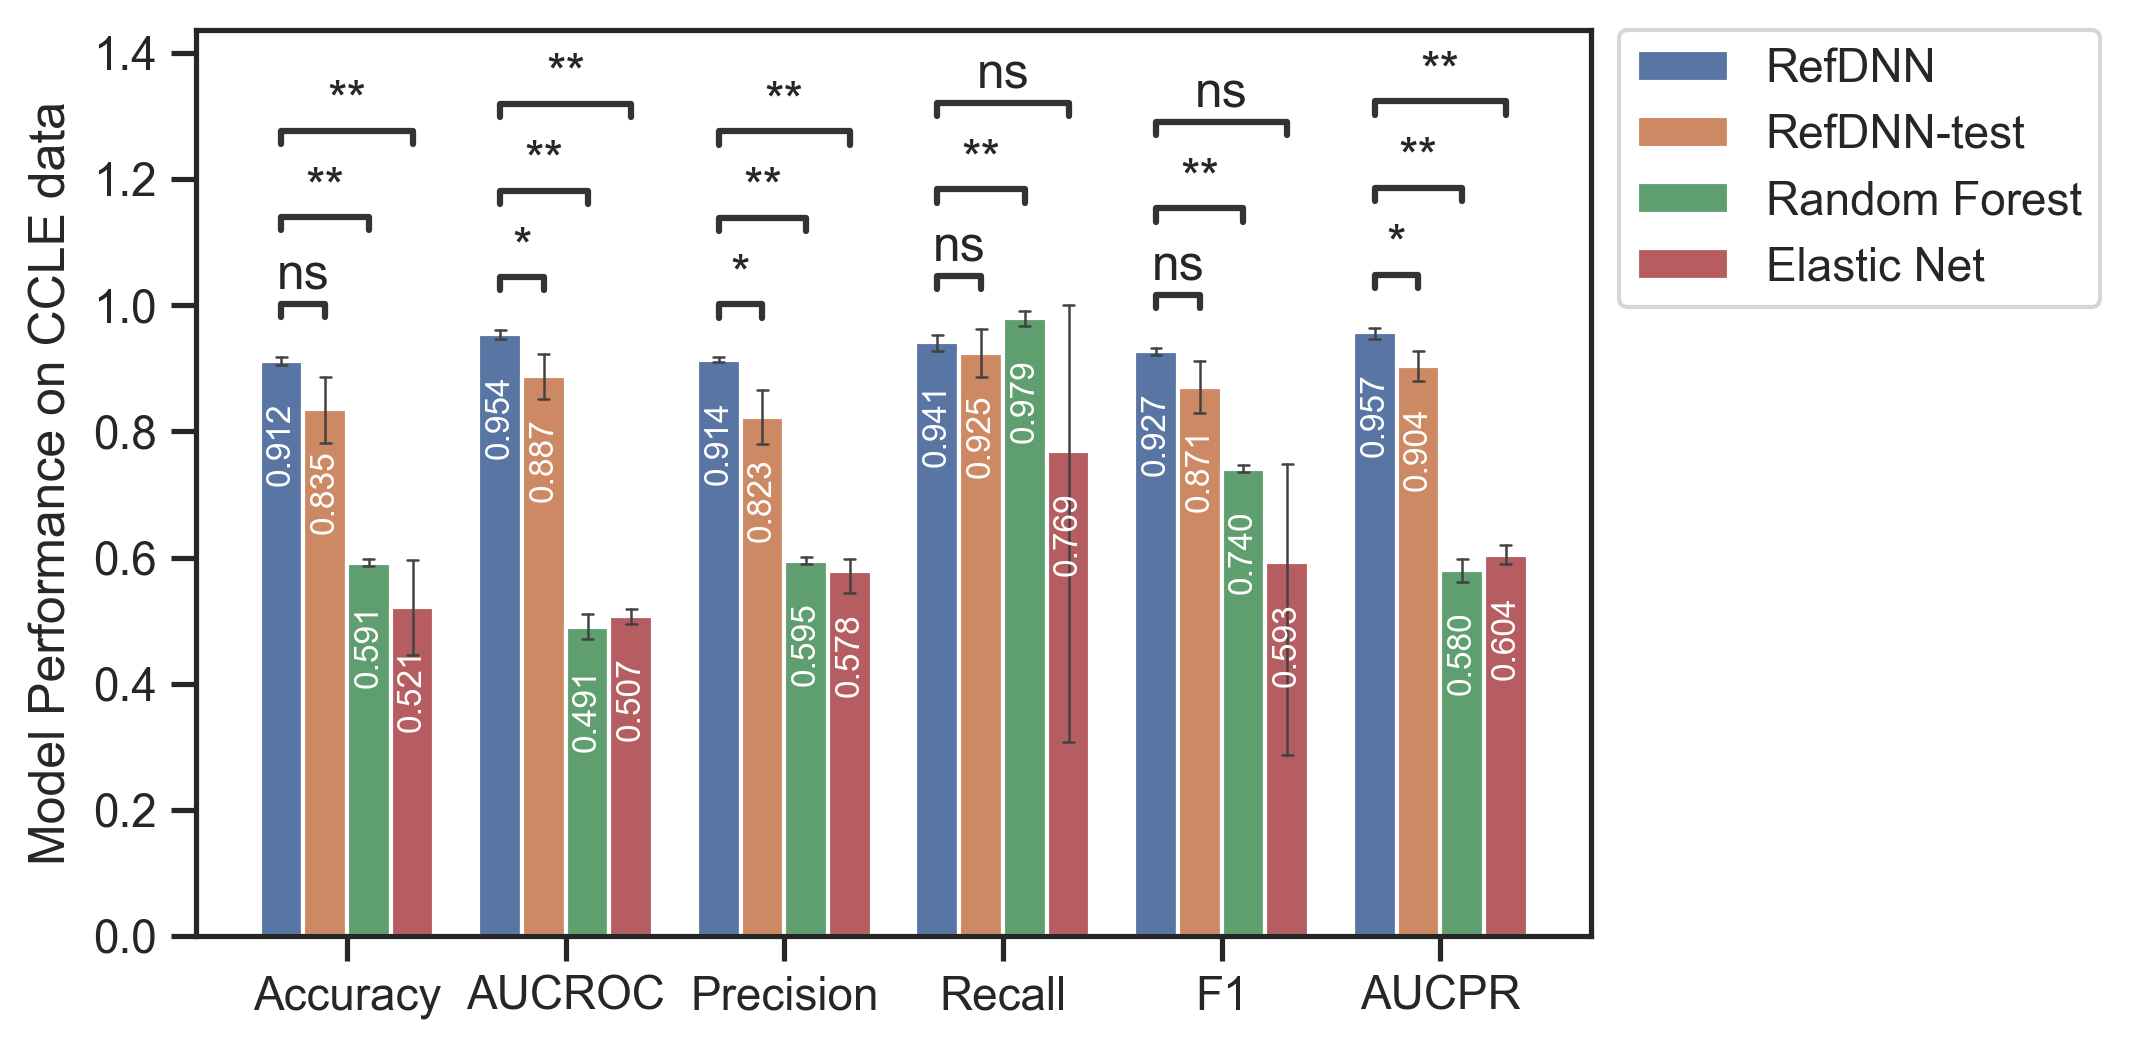

In [13]:
# label statistical test result on the plot

p_values = list(p_values_df_CCLE['RefDNN-test Labels']) + list(p_values_df_CCLE['Random Forest Labels']) + list(p_values_df_CCLE['Elastic Net Labels'])

pairs = [[('Accuracy', 'RefDNN'), ('Accuracy', 'RefDNN-test')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'RefDNN-test')],
         [('Precision', 'RefDNN'), ('Precision', 'RefDNN-test')],
         [('Recall', 'RefDNN'), ('Recall', 'RefDNN-test')],
         [('F1', 'RefDNN'), ('F1', 'RefDNN-test')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'RefDNN-test')],
         [('Accuracy', 'RefDNN'), ('Accuracy', 'Random Forest')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'Random Forest')],
         [('Precision', 'RefDNN'), ('Precision', 'Random Forest')],
         [('Recall', 'RefDNN'), ('Recall', 'Random Forest')],
         [('F1', 'RefDNN'), ('F1', 'Random Forest')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'Random Forest')],
         [('Accuracy', 'RefDNN'), ('Accuracy', 'Elastic Net')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'Elastic Net')],
         [('Precision', 'RefDNN'), ('Precision', 'Elastic Net')],
         [('Recall', 'RefDNN'), ('Recall', 'Elastic Net')],
         [('F1', 'RefDNN'), ('F1', 'Elastic Net')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'Elastic Net')]]

models = ['RefDNN', 'RefDNN-test', 'Random Forest', 'Elastic Net']
metrics = ['Accuracy', 'AUCROC', 'Precision', 'Recall', 'F1', 'AUCPR']


# Putting the parameters in a dictionary avoids code duplication
plotting_parameters = {
    'data':    CCLE_metrics_tidy,
    'x':       'metric',
    'y':       'value',
    'hue': 'model',
    'hue_order': models,
    'order': metrics,
    'errwidth': 0.6,
    'capsize': 0.05
}

ax = sb.barplot(**plotting_parameters);
for i in ax.containers:
    ax.bar_label(i, size=8, fmt='%.3f', padding= -30, rotation=90, color='white')
plt.xlabel('');
plt.ylabel('Model Performance on CCLE data');
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters);
annotator.set_custom_annotations(p_values);
annotator.annotate();

# GDSC

In [14]:
# check final output files
!ls ../output_raw

1_RefDNN_CCLE.csv              2_lococv_elasticnet_GDSC.csv
1_RefDNN_CCLE_test.csv         2_lococv_randomforest_CCLE.csv
1_RefDNN_GDSC.csv              2_lococv_randomforest_GDSC.csv
1_RefDNN_GDSC_test.csv         3_lodocv_RefDNN_CCLE.csv
1_elasticnet_CCLE.csv          3_lodocv_RefDNN_GDSC.csv
1_elasticnet_GDSC.csv          3_lodocv_elasticnet_CCLE.csv
1_randomforest_CCLE.csv        3_lodocv_elasticnet_GDSC.csv
1_randomforest_GDSC.csv        3_lodocv_randomforest_CCLE.csv
2_lococv_RefDNN_CCLE.csv       3_lodocv_randomforest_GDSC.csv
2_lococv_RefDNN_GDSC.csv       4_biomarker_CCLE.csv
2_lococv_elasticnet_CCLE.csv   4_biomarker_GDSC.csv


### 1. Read data

In [15]:
GDSC_RefDNN = pd.read_csv("../output_raw/1_RefDNN_GDSC.csv", index_col=[0])
GDSC_RefDNN

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,Hidden_units,Learning_rate_ftrl,Learning_rate_adam,L1_regularization_strength,L2_regularization_strength
0,0.824063,0.850545,0.876752,0.863450,0.897532,0.936474,117,0.000019,0.000460,0.001000,100.000000
1,0.817139,0.849710,0.864180,0.856884,0.892275,0.932634,95,0.000006,0.021411,0.120788,23.213440
2,0.824611,0.878926,0.839451,0.858735,0.903392,0.940368,76,0.000027,0.000976,0.001904,0.047300
3,0.818691,0.868432,0.842526,0.855283,0.894643,0.935219,4,0.000005,0.003887,0.001000,0.895344
4,0.809404,0.819754,0.896728,0.856515,0.887925,0.931160,122,0.000002,0.000230,0.006824,0.200862


In [16]:
GDSC_RefDNN_test = pd.read_csv("../output_raw/1_RefDNN_GDSC_test.csv", index_col=[0])
GDSC_RefDNN_test

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,Hidden_units,Learning_rate_adam
0,0.722190,0.736084,0.876797,0.800303,0.771454,0.848377,47,0.000247
1,0.738890,0.740353,0.904615,0.814283,0.786494,0.852734,36,0.000130
2,0.734259,0.760074,0.851298,0.803104,0.791384,0.867253,128,0.000099
3,0.742074,0.745171,0.900793,0.815626,0.792703,0.858811,99,0.000103
4,0.729366,0.750072,0.861164,0.801788,0.774264,0.848732,25,0.000401


In [17]:
GDSC_elasticnet = pd.read_csv("../output_raw/1_elasticnet_GDSC.csv", index_col=[0])
GDSC_elasticnet

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,ALPHA,L1_RATIO,ETA0
0,0.622869,0.664644,0.817925,0.733361,0.598634,0.715481,0.008176,0.100000,0.000010
1,0.636699,0.636699,1.000000,0.778028,0.602221,0.717240,0.026712,0.139490,0.099697
2,0.638172,0.640261,0.976705,0.773480,0.607585,0.716323,0.030615,0.100000,0.000010
3,0.455548,0.783421,0.202335,0.321608,0.556825,0.670383,0.000022,0.506396,0.000060
4,0.632147,0.632272,0.999251,0.774489,0.577867,0.688447,0.038048,0.511116,0.099746


In [18]:
GDSC_randomforest = pd.read_csv("../output_raw/1_randomforest_GDSC.csv", index_col=[0])
GDSC_randomforest

,Accuracy,Precision,Recall,F1,AUCROC,AUCPR,N_ESTIMTORS,MAX_DEPTH
0,0.643496,0.649868,0.945263,0.770214,0.629040,0.734892,34,8
1,0.642934,0.653777,0.927212,0.766849,0.626726,0.736837,69,10
2,0.646486,0.656768,0.928435,0.769323,0.628722,0.737619,70,10
3,0.646276,0.657033,0.929923,0.770015,0.626968,0.738207,10,10
4,0.644223,0.652003,0.945239,0.771704,0.624940,0.735501,54,7


### 2. Data wrangling and cleaning

In [19]:
# make the data tidy for visualization
GDSC_RefDNN_metrics = GDSC_RefDNN[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
GDSC_RefDNN_metrics_tidy = pd.melt(GDSC_RefDNN_metrics, value_vars=list(GDSC_RefDNN_metrics), var_name='metric', value_name='value')
GDSC_RefDNN_metrics_tidy['model'] = 'RefDNN'

GDSC_RefDNN_test_metrics = GDSC_RefDNN_test[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
GDSC_RefDNN_test_metrics_tidy = pd.melt(GDSC_RefDNN_test_metrics, value_vars=list(GDSC_RefDNN_test_metrics), var_name='metric', value_name='value')
GDSC_RefDNN_test_metrics_tidy['model'] = 'RefDNN-test'

GDSC_elasticnet_metrics = GDSC_elasticnet[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
GDSC_elasticnet_metrics_tidy = pd.melt(GDSC_elasticnet_metrics, value_vars=list(GDSC_elasticnet_metrics), var_name='metric', value_name='value')
GDSC_elasticnet_metrics_tidy['model'] = 'Elastic Net'

GDSC_randomforest_metrics = GDSC_randomforest[['Accuracy', 'Precision', 'Recall', 'F1', 'AUCROC', 'AUCPR']]
GDSC_randomforest_metrics_tidy = pd.melt(GDSC_randomforest_metrics, value_vars=list(GDSC_randomforest_metrics), var_name='metric', value_name='value')
GDSC_randomforest_metrics_tidy['model'] = 'Random Forest'

GDSC_metrics_tidy = pd.concat([GDSC_RefDNN_metrics_tidy, GDSC_RefDNN_test_metrics_tidy, GDSC_elasticnet_metrics_tidy, GDSC_randomforest_metrics_tidy], ignore_index=True)
GDSC_metrics_tidy

,metric,value,model
0,Accuracy,0.824063,RefDNN
1,Accuracy,0.817139,RefDNN
2,Accuracy,0.824611,RefDNN
3,Accuracy,0.818691,RefDNN
4,Accuracy,0.809404,RefDNN
...,...,...,...
115,AUCPR,0.734892,Random Forest
116,AUCPR,0.736837,Random Forest
117,AUCPR,0.737619,Random Forest
118,AUCPR,0.738207,Random Forest


In [20]:
# calculate statistics
GDSC_statistics = GDSC_metrics_tidy.groupby(['model', 'metric'])['value'].describe()[['mean', 'std']]
GDSC_statistics = GDSC_statistics.reset_index().melt(id_vars=['model', 'metric'], value_vars=['mean','std'], var_name='statistics', value_name='value')
GDSC_statistics = GDSC_statistics.sort_values(by=['model','statistics']).pivot(index='metric', columns=['model','statistics'], values=['value'])
GDSC_statistics.columns = [col[1]+' ('+col[2]+')' for col in GDSC_statistics.columns.values]
#GDSC_statistics.to_csv('../analysis_output/1_Bayesian_GDSC_metrics.csv')
GDSC_statistics

,Elastic Net (mean),Elastic Net (std),Random Forest (mean),Random Forest (std),RefDNN (mean),RefDNN (std),RefDNN-test (mean),RefDNN-test (std)
metric,,,,,,,,
AUCPR,0.701575,0.021223,0.736612,0.001397,0.935171,0.003579,0.855182,0.007949
AUCROC,0.588626,0.021045,0.627279,0.001663,0.895153,0.005795,0.783260,0.009823
Accuracy,0.597087,0.079348,0.644683,0.001618,0.818782,0.006175,0.733356,0.007875
F1,0.676193,0.199058,0.769621,0.001776,0.858173,0.003199,0.807021,0.007325
Precision,0.671459,0.063834,0.653890,0.003079,0.853473,0.022535,0.746351,0.009286
Recall,0.799243,0.342216,0.935215,0.009212,0.863927,0.023966,0.878934,0.023566


### 3. A quick visualization

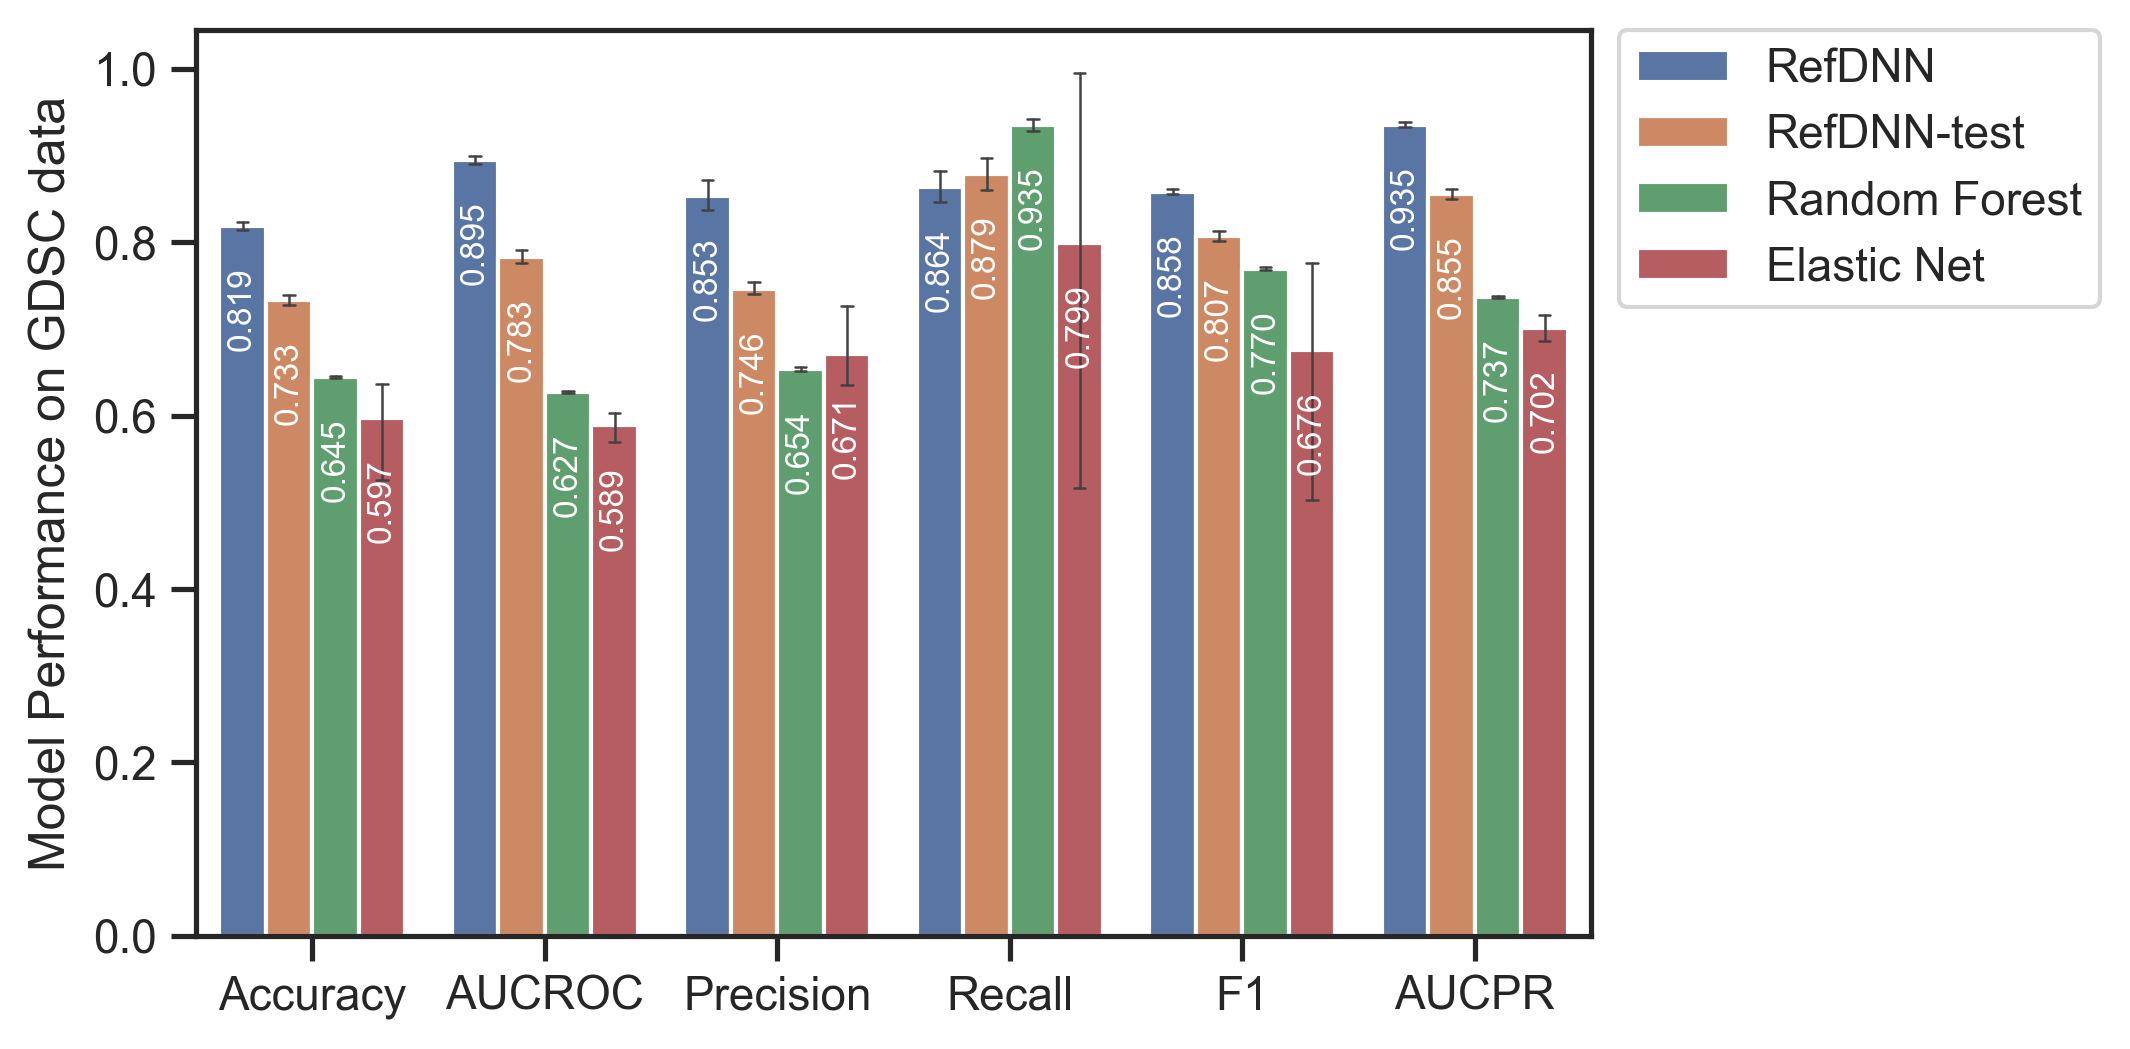

In [21]:
hue_order = ['RefDNN', 'RefDNN-test', 'Random Forest', 'Elastic Net']
x_order = ['Accuracy', 'AUCROC', 'Precision', 'Recall', 'F1', 'AUCPR']
ax = sb.barplot(data=GDSC_metrics_tidy, x='metric', y='value', hue = 'model', 
           hue_order=hue_order, order=x_order, errwidth=0.6, capsize=.05);
for i in ax.containers:
    ax.bar_label(i, size=8, fmt='%.3f', padding= -30, rotation=90, color='white')
plt.xlabel('')
plt.ylabel('Model Performance on GDSC data');
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### 4. Statistical test

In [22]:
p_values_df_GDSC = pd.DataFrame()
p_values_df_GDSC['metric'] = metrics
p_values_test, p_values_rf, p_values_en = [], [], []

for metric in metrics:
    refDNN_values = list(GDSC_metrics_tidy[(GDSC_metrics_tidy['metric']==metric) & (GDSC_metrics_tidy['model']=='RefDNN')]['value'])
    refDNN_test_values = list(GDSC_metrics_tidy[(GDSC_metrics_tidy['metric']==metric) & (GDSC_metrics_tidy['model']=='RefDNN-test')]['value'])
    rf_values = list(GDSC_metrics_tidy[(GDSC_metrics_tidy['metric']==metric) & (GDSC_metrics_tidy['model']=='Random Forest')]['value'])
    en_values = list(GDSC_metrics_tidy[(GDSC_metrics_tidy['metric']==metric) & (GDSC_metrics_tidy['model']=='Elastic Net')]['value'])
    p_values_test.append(ttest_ind(refDNN_values, refDNN_test_values, equal_var=False)[1])
    p_values_rf.append(ttest_ind(refDNN_values, rf_values, equal_var=False)[1])
    p_values_en.append(ttest_ind(refDNN_values, en_values, equal_var=False)[1])
    
p_values_df_GDSC['RefDNN-test'] = p_values_test
p_values_df_GDSC['Random Forest'] = p_values_rf
p_values_df_GDSC['Elastic Net'] = p_values_en
p_values_df_GDSC

,metric,RefDNN-test,Random Forest,Elastic Net
0,Accuracy,1.122158e-07,8.456100e-08,0.003251
1,AUCROC,2.504116e-07,6.361802e-09,0.000002
2,Precision,1.306468e-04,3.000068e-05,0.001853
3,Recall,3.473695e-01,1.416520e-03,0.694775
4,F1,1.520408e-05,1.365978e-09,0.110409
5,AUCPR,1.879905e-06,4.697686e-10,0.000011


In [23]:
# multi-test correction
p_adjusted = multipletests(list(p_values_df_GDSC['RefDNN-test']) + list(p_values_df_GDSC['Random Forest']) + list(p_values_df_GDSC['Elastic Net']), 
                           alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
p_values_df_GDSC['RefDNN-test adjusted'] = p_adjusted[1][0:6]
p_values_df_GDSC['Random Forest adjusted'] = p_adjusted[1][6:12]
p_values_df_GDSC['Elastic Net adjusted'] = p_adjusted[1][12:]
p_values_df_GDSC

,metric,RefDNN-test,Random Forest,Elastic Net,RefDNN-test adjusted,Random Forest adjusted,Elastic Net adjusted
0,Accuracy,1.122158e-07,8.456100e-08,0.003251,4.039768e-07,3.805245e-07,0.003901
1,AUCROC,2.504116e-07,6.361802e-09,0.000002,7.512348e-07,3.817081e-08,0.000004
2,Precision,1.306468e-04,3.000068e-05,0.001853,1.959702e-04,4.909202e-05,0.002382
3,Recall,3.473695e-01,1.416520e-03,0.694775,3.678030e-01,1.961336e-03,0.694775
4,F1,1.520408e-05,1.365978e-09,0.110409,2.736734e-05,1.229380e-08,0.124210
5,AUCPR,1.879905e-06,4.697686e-10,0.000011,4.229786e-06,8.455835e-09,0.000021


In [24]:
# generate the labels for statistical test result
p_values_df_GDSC['RefDNN-test Labels'] = p_values_df_GDSC['RefDNN-test adjusted'].apply(lambda p: '**' if p<0.01 else('*' if p<0.05 else 'ns'))
p_values_df_GDSC['Random Forest Labels'] = p_values_df_GDSC['Random Forest adjusted'].apply(lambda p: '**' if p<0.01 else('*' if p<0.05 else 'ns'))
p_values_df_GDSC['Elastic Net Labels'] = p_values_df_GDSC['Elastic Net adjusted'].apply(lambda p: '**' if p<0.01 else('*' if p<0.05 else 'ns'))
#p_values_df_GDSC.to_csv('../analysis_output/1_Bayesian_GDSC_statistical_test.csv')
p_values_df_GDSC

,metric,RefDNN-test,Random Forest,Elastic Net,RefDNN-test adjusted,Random Forest adjusted,Elastic Net adjusted,RefDNN-test Labels,Random Forest Labels,Elastic Net Labels
0,Accuracy,1.122158e-07,8.456100e-08,0.003251,4.039768e-07,3.805245e-07,0.003901,**,**,**
1,AUCROC,2.504116e-07,6.361802e-09,0.000002,7.512348e-07,3.817081e-08,0.000004,**,**,**
2,Precision,1.306468e-04,3.000068e-05,0.001853,1.959702e-04,4.909202e-05,0.002382,**,**,**
3,Recall,3.473695e-01,1.416520e-03,0.694775,3.678030e-01,1.961336e-03,0.694775,ns,**,ns
4,F1,1.520408e-05,1.365978e-09,0.110409,2.736734e-05,1.229380e-08,0.124210,**,**,ns
5,AUCPR,1.879905e-06,4.697686e-10,0.000011,4.229786e-06,8.455835e-09,0.000021,**,**,**


### 5. Add statistical test result to the plot

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Recall_RefDNN vs. Recall_RefDNN-test: ns
F1_RefDNN vs. F1_RefDNN-test: **
Precision_RefDNN vs. Precision_RefDNN-test: **
Accuracy_RefDNN vs. Accuracy_RefDNN-test: **
AUCROC_RefDNN vs. AUCROC_RefDNN-test: **
AUCPR_RefDNN vs. AUCPR_RefDNN-test: **
F1_RefDNN vs. F1_Random Forest: **
AUCPR_RefDNN vs. AUCPR_Random Forest: **
Recall_RefDNN vs. Recall_Random Forest: **
Accuracy_RefDNN vs. Accuracy_Random Forest: **
AUCROC_RefDNN vs. AUCROC_Random Forest: **
Precision_RefDNN vs. Precision_Random Forest: **
Recall_RefDNN vs. Recall_Elastic Net: ns
F1_RefDNN vs. F1_Elastic Net: ns
AUCPR_RefDNN vs. AUCPR_Elastic Net: **
Precision_RefDNN vs. Precision_Elastic Net: **
Accuracy_RefDNN vs. Accuracy_Elastic Net: **
AUCROC_RefDNN vs. AUCROC_Elastic Net: **


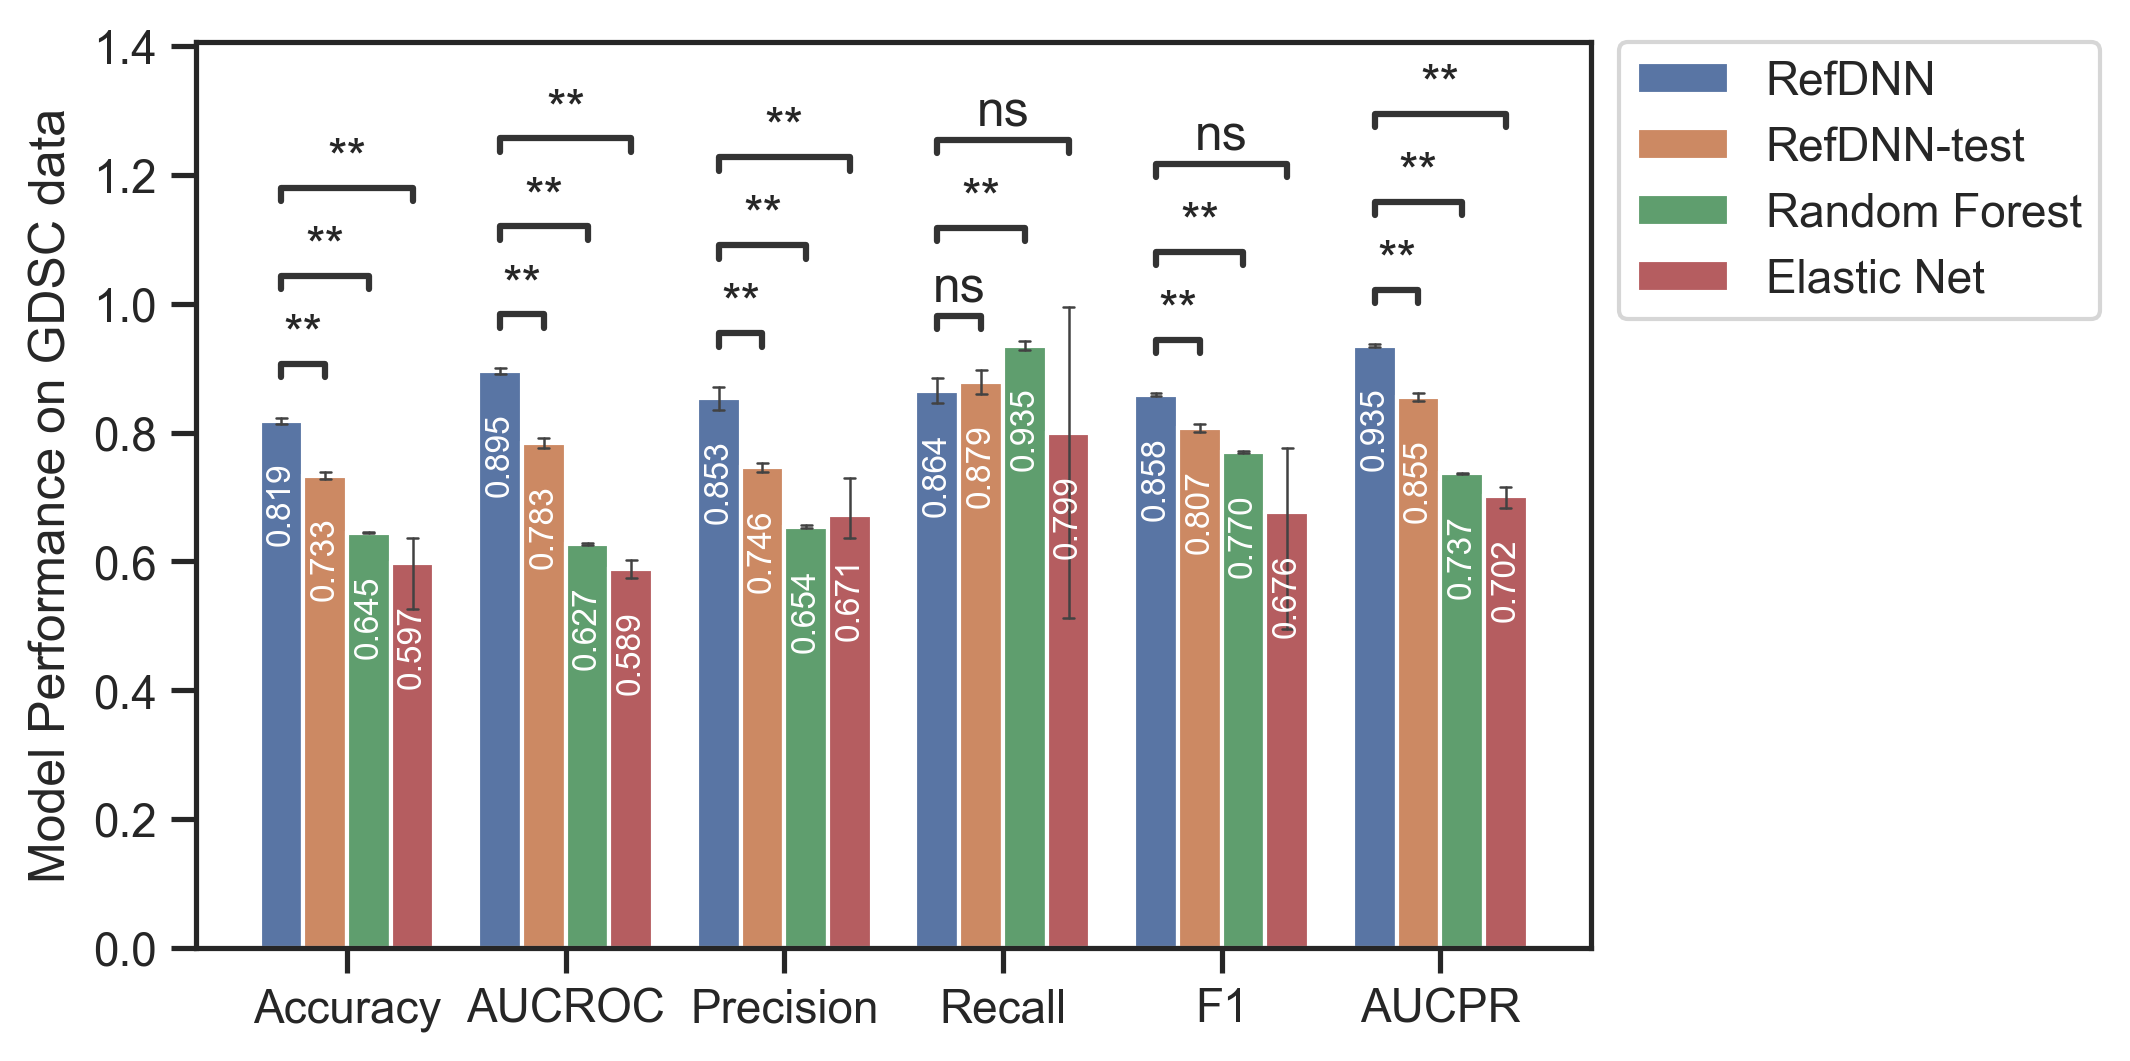

In [25]:
# label statistical test result on the plot

p_values = list(p_values_df_GDSC['RefDNN-test Labels']) + list(p_values_df_GDSC['Random Forest Labels']) + list(p_values_df_GDSC['Elastic Net Labels'])

pairs = [[('Accuracy', 'RefDNN'), ('Accuracy', 'RefDNN-test')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'RefDNN-test')],
         [('Precision', 'RefDNN'), ('Precision', 'RefDNN-test')],
         [('Recall', 'RefDNN'), ('Recall', 'RefDNN-test')],
         [('F1', 'RefDNN'), ('F1', 'RefDNN-test')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'RefDNN-test')],
         [('Accuracy', 'RefDNN'), ('Accuracy', 'Random Forest')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'Random Forest')],
         [('Precision', 'RefDNN'), ('Precision', 'Random Forest')],
         [('Recall', 'RefDNN'), ('Recall', 'Random Forest')],
         [('F1', 'RefDNN'), ('F1', 'Random Forest')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'Random Forest')],
         [('Accuracy', 'RefDNN'), ('Accuracy', 'Elastic Net')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'Elastic Net')],
         [('Precision', 'RefDNN'), ('Precision', 'Elastic Net')],
         [('Recall', 'RefDNN'), ('Recall', 'Elastic Net')],
         [('F1', 'RefDNN'), ('F1', 'Elastic Net')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'Elastic Net')]]

models = ['RefDNN', 'RefDNN-test', 'Random Forest', 'Elastic Net']
metrics = ['Accuracy', 'AUCROC', 'Precision', 'Recall', 'F1', 'AUCPR']


# Putting the parameters in a dictionary avoids code duplication
plotting_parameters = {
    'data':    GDSC_metrics_tidy,
    'x':       'metric',
    'y':       'value',
    'hue': 'model',
    'hue_order': models,
    'order': metrics,
    'errwidth': 0.6,
    'capsize': 0.05
}

ax = sb.barplot(**plotting_parameters);
for i in ax.containers:
    ax.bar_label(i, size=8, fmt='%.3f', padding= -30, rotation=90, color='white')
plt.xlabel('');
plt.ylabel('Model Performance on GDSC data');
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters);
annotator.set_custom_annotations(p_values);
annotator.annotate();

# Prepare the final figure for the report

In [26]:
# set up parameters

pairs = [[('Accuracy', 'RefDNN'), ('Accuracy', 'RefDNN-test')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'RefDNN-test')],
         [('Precision', 'RefDNN'), ('Precision', 'RefDNN-test')],
         [('Recall', 'RefDNN'), ('Recall', 'RefDNN-test')],
         [('F1', 'RefDNN'), ('F1', 'RefDNN-test')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'RefDNN-test')],
         [('Accuracy', 'RefDNN'), ('Accuracy', 'Random Forest')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'Random Forest')],
         [('Precision', 'RefDNN'), ('Precision', 'Random Forest')],
         [('Recall', 'RefDNN'), ('Recall', 'Random Forest')],
         [('F1', 'RefDNN'), ('F1', 'Random Forest')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'Random Forest')],
         [('Accuracy', 'RefDNN'), ('Accuracy', 'Elastic Net')],
         [('AUCROC', 'RefDNN'), ('AUCROC', 'Elastic Net')],
         [('Precision', 'RefDNN'), ('Precision', 'Elastic Net')],
         [('Recall', 'RefDNN'), ('Recall', 'Elastic Net')],
         [('F1', 'RefDNN'), ('F1', 'Elastic Net')],
         [('AUCPR', 'RefDNN'), ('AUCPR', 'Elastic Net')]]

p_values_dict = dict()
p_values_dict['CCLE'] = list(p_values_df_CCLE['RefDNN-test Labels']) + \
                    list(p_values_df_CCLE['Random Forest Labels']) + \
                    list(p_values_df_CCLE['Elastic Net Labels'])
p_values_dict['GDSC'] = list(p_values_df_GDSC['RefDNN-test Labels']) + \
                    list(p_values_df_GDSC['Random Forest Labels']) + \
                    list(p_values_df_GDSC['Elastic Net Labels'])

models = ['RefDNN', 'RefDNN-test', 'Random Forest', 'Elastic Net']
metrics = ['Accuracy', 'AUCROC', 'Precision', 'Recall', 'F1', 'AUCPR']

plotting_parameters = {
    'data':    CCLE_metrics_tidy,
    'x':       'metric',
    'y':       'value',
    'hue': 'model',
    'hue_order': models,
    'order': metrics,
    'errwidth': 1.2,
    'capsize': 0.1
}

In [27]:
def plot_data_final(dataset, figure_label, p_values_dict=p_values_dict, plotting_parameters=plotting_parameters, pairs=pairs):
    if dataset=='GDSC':
        plotting_parameters['data'] = GDSC_metrics_tidy    
    
    ax = sb.barplot(**plotting_parameters);
    for i in ax.containers:
        ax.bar_label(i, fmt='%.3f', padding= -40, rotation=90, color='white', size = 14)
    plt.xlabel('');
    plt.ylabel(f'Performance ({dataset})');
    plt.xticks(rotation=45)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
    plt.annotate(figure_label, weight='bold', xy=(0, 1), xycoords='axes fraction', xytext=(-80, 10), 
                 textcoords='offset points',horizontalalignment='left', verticalalignment='top')
    annotator = Annotator(ax, pairs, **plotting_parameters);
    annotator.set_custom_annotations(p_values_dict[dataset]);
    annotator.annotate();

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Recall_RefDNN vs. Recall_RefDNN-test: ns
F1_RefDNN vs. F1_RefDNN-test: ns
Precision_RefDNN vs. Precision_RefDNN-test: *
Accuracy_RefDNN vs. Accuracy_RefDNN-test: ns
AUCROC_RefDNN vs. AUCROC_RefDNN-test: *
AUCPR_RefDNN vs. AUCPR_RefDNN-test: *
F1_RefDNN vs. F1_Random Forest: **
AUCPR_RefDNN vs. AUCPR_Random Forest: **
Recall_RefDNN vs. Recall_Random Forest: **
Accuracy_RefDNN vs. Accuracy_Random Forest: **
AUCROC_RefDNN vs. AUCROC_Random Forest: **
Precision_RefDNN vs. Precision_Random Forest: **
Recall_RefDNN vs. Recall_Elastic Net: ns
F1_RefDNN vs. F1_Elastic Net: ns
AUCPR_RefDNN vs. AUCPR_Elastic Net: **
Precision_RefDNN vs. Precision_Elastic Net: **
Accuracy_RefDNN vs. Accuracy_Elastic Net: **
AUCROC_RefDNN vs. AUCROC_Elastic Net: **
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < 

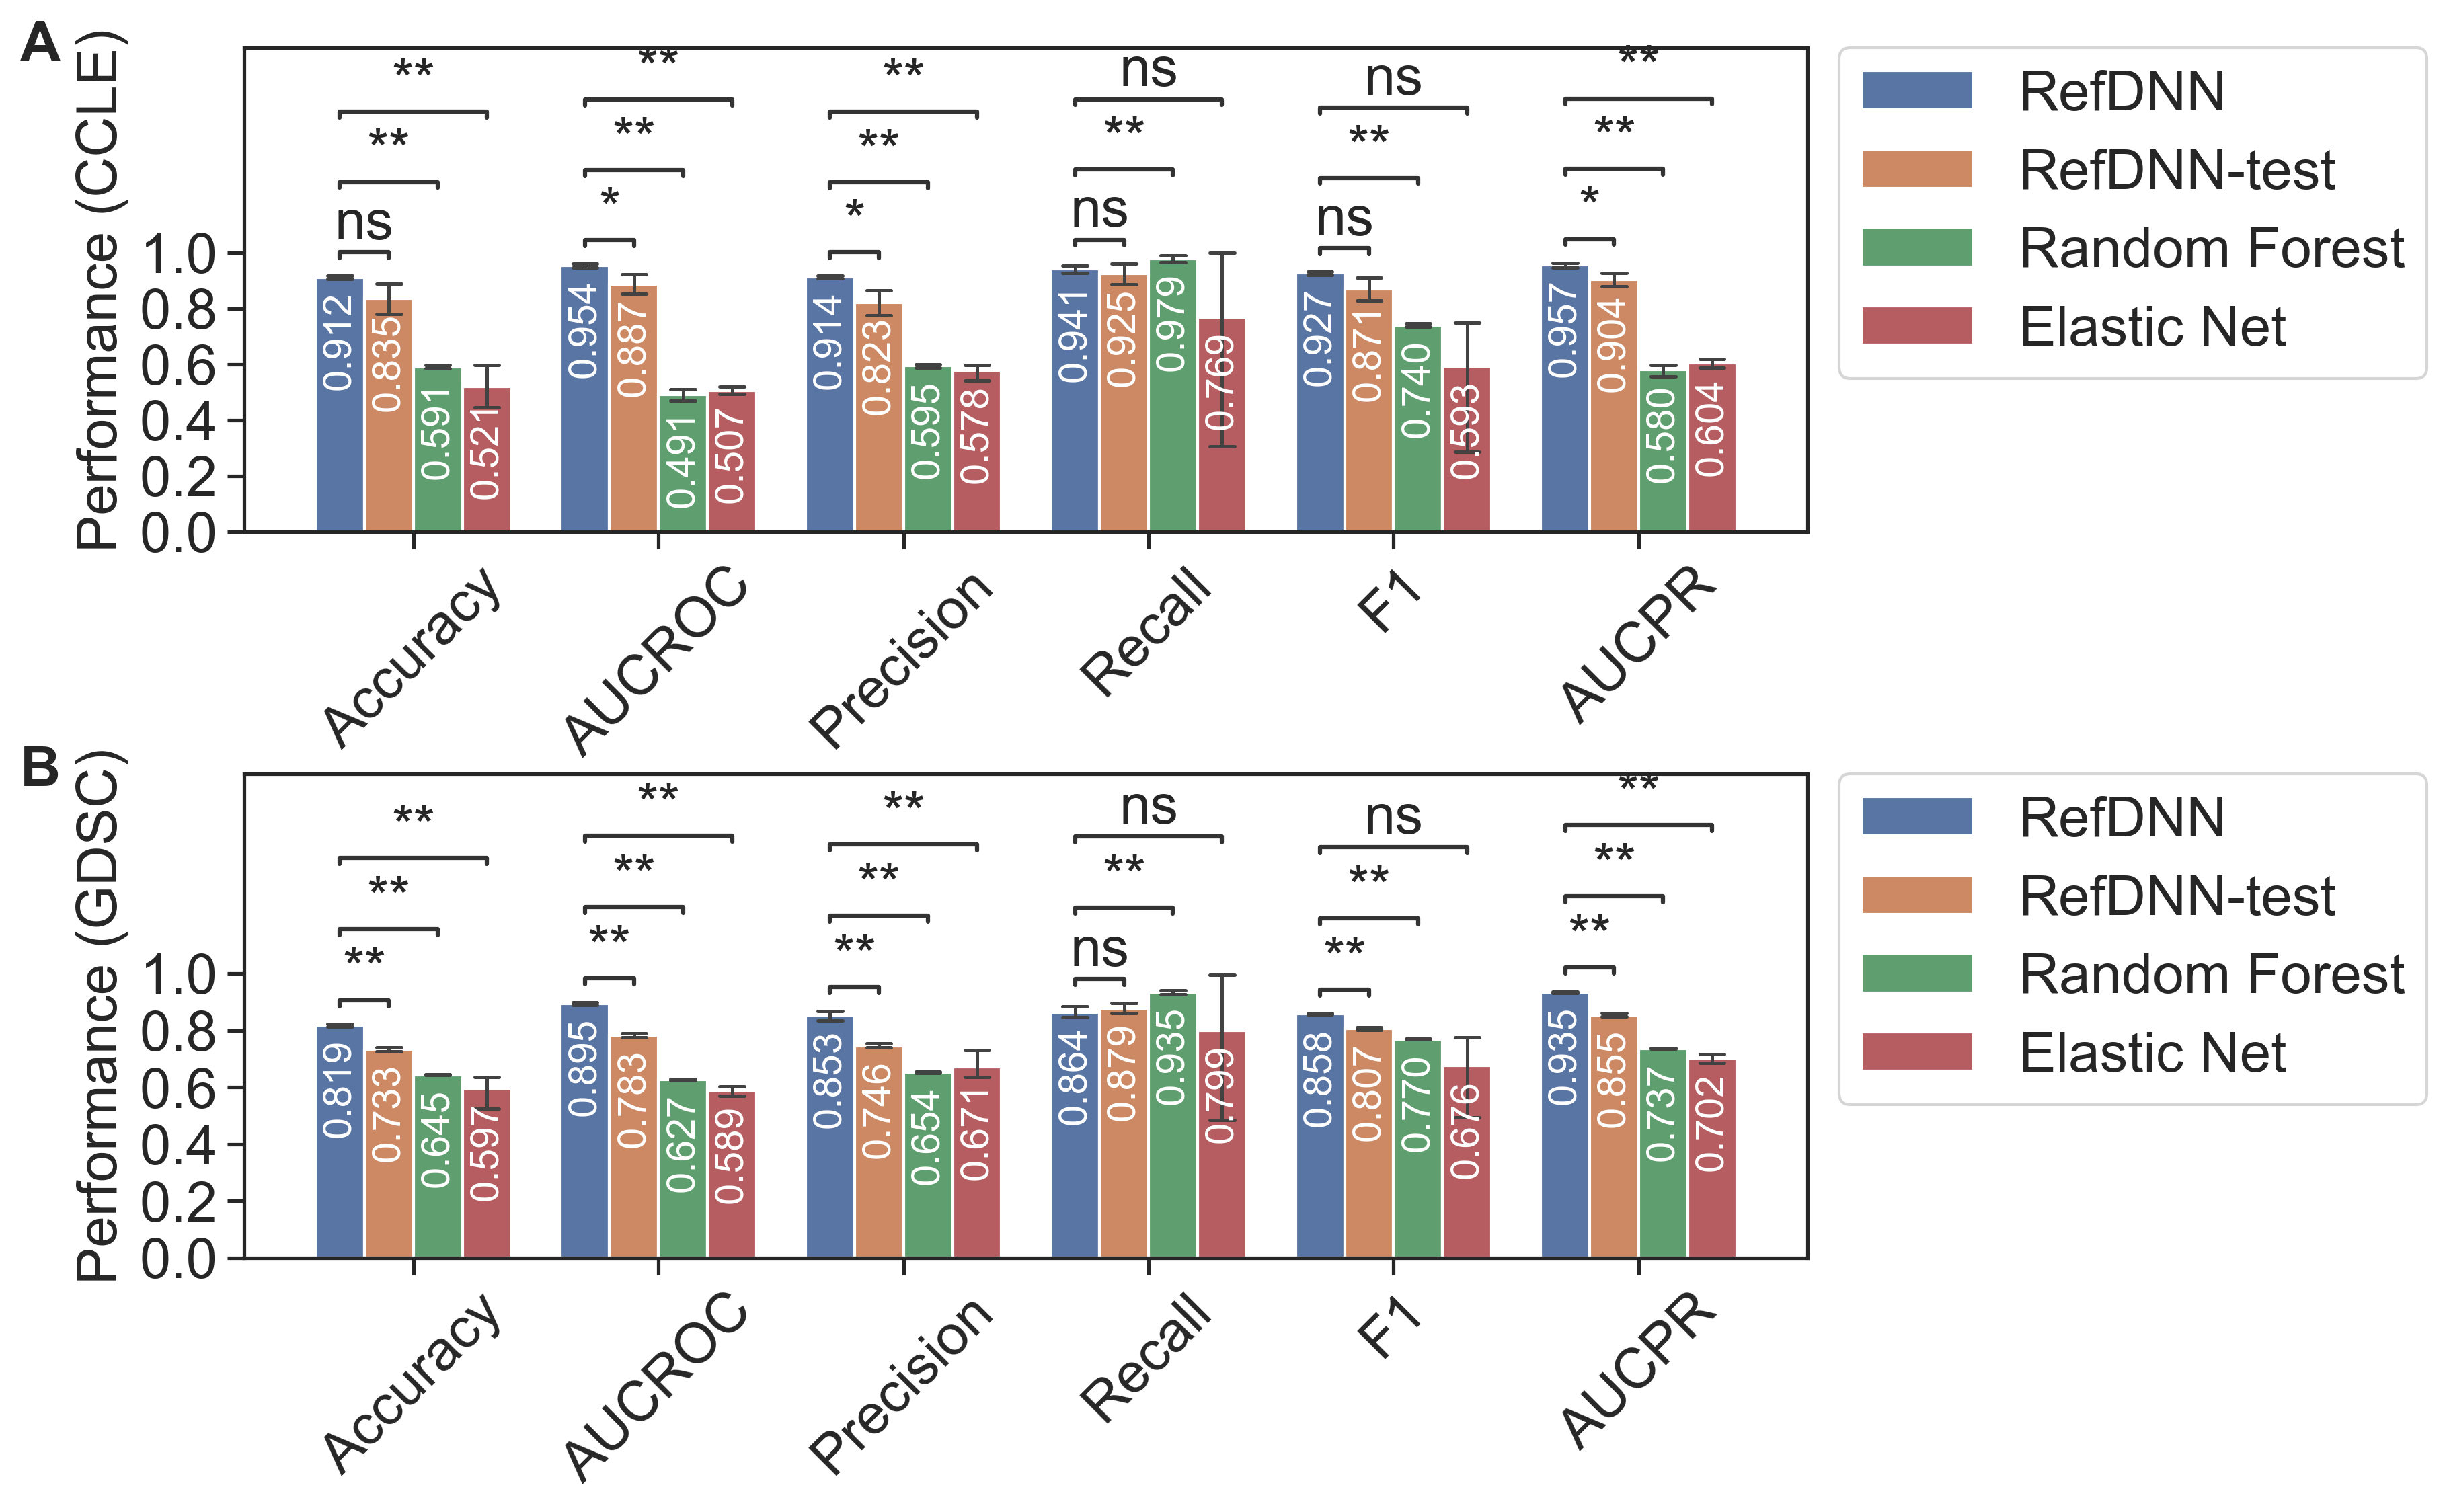

In [28]:
# plot and save figure
params = {
   'axes.labelsize': 20,
   'font.size': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': False,
   'figure.figsize': [10,8]
   }
rcParams.update(params)
plt.subplots_adjust(left=0.125, bottom=0.05, right=0.9, top=0.8, wspace=0.3, hspace=0.5)

plt.subplot(2,1,1)
plot_data_final('CCLE', 'A')

plt.subplot(2,1,2)
plot_data_final('GDSC', 'B')

plt.savefig("../analysis_output/figure1.png", bbox_inches='tight');